In [22]:
# prompt: 读取amzn_base 和 amzn_predict 这两个xlsx表格并输出出来，注意里面第二列格式是Date

import pandas as pd
from datetime import datetime

# Read the first excel file
amzn_base = pd.read_excel("amzn_base.xlsx")

# Convert the second column to datetime format
amzn_base['Date'] = pd.to_datetime(amzn_base['Date'], format="%Y-%m-%d")

# Read the second excel file
amzn_predict = pd.read_excel("amzn_predict.xlsx")

# Convert the second column to datetime format
amzn_predict['Date'] = pd.to_datetime(amzn_predict['Date'], format="%Y-%m-%d")

# Print both dataframes
amzn_base['Close']
amzn_predict['Close']


0     149.93
1     148.47
2     144.57
3     145.24
4     149.10
5     151.37
6     153.73
7     155.18
8     154.62
9     153.16
10    151.71
11    153.38
12    155.34
13    154.78
14    156.02
15    156.87
16    157.75
17    159.12
18    161.26
19    159.00
20    155.20
21    159.28
22    171.81
23    170.31
24    169.15
25    170.53
26    169.84
27    174.45
28    172.34
29    168.64
30    170.98
31    169.80
Name: Close, dtype: float64

In [4]:
# prompt: 利用amzn_base里面的Date和Close利用sarimax方法预测未来30天的价格

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train the SARIMAX model
model = SARIMAX(amzn_base['Close'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
results = model.fit()

# Make predictions for the next 30 days
forecast = results.forecast(30)

# Print the predictions
print(forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1006    151.964016
1007    151.959479
1008    151.957979
1009    151.856326
1010    151.807478
1011    151.861370
1012    151.809143
1013    151.807889
1014    151.772214
1015    151.780735
1016    151.785094
1017    151.788534
1018    151.766839
1019    151.789251
1020    151.770538
1021    151.730243
1022    151.695274
1023    151.730290
1024    151.698024
1025    151.700912
1026    151.679657
1027    151.685975
1028    151.686919
1029    151.689691
1030    151.677622
1031    151.689872
1032    151.679701
1033    151.658854
1034    151.640341
1035    151.658826
Name: predicted_mean, dtype: float64


In [27]:
# prompt: 利用amzn_base里面的Close利用LSTM方法预测未来30天的价格

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# Assuming 'amzn_base' is already loaded and contains the 'Date' and 'Close' columns

# Select the 'Close' column
close_prices = amzn_base['Close'].values.reshape(-1, 1)

# Scale the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices)

# Function to create dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Prepare the data with a look_back period
look_back = 30
X, Y = create_dataset(scaled_prices, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Splitting dataset into train and test split
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model.fit(trainX, trainY, epochs=100, batch_size=32, validation_data=(testX, testY), callbacks=[early_stop], verbose=2)

# Making predictions
def predict_next_30_days(model, last_30_days_scaled):
    prediction_list = last_30_days_scaled
    for _ in range(30):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back:]
    return prediction_list

# Predict the next 30 days
last_30_days_scaled = scaled_prices[-look_back:]
predicted_next_30 = predict_next_30_days(model, last_30_days_scaled)
predicted_next_30 = scaler.inverse_transform(predicted_next_30.reshape(-1, 1))

# Print or plot your predictions
predicted_next_30



Epoch 1/100
25/25 - 8s - loss: 0.0933 - val_loss: 0.0056 - 8s/epoch - 339ms/step
Epoch 2/100
25/25 - 1s - loss: 0.0097 - val_loss: 0.0019 - 750ms/epoch - 30ms/step
Epoch 3/100
25/25 - 1s - loss: 0.0055 - val_loss: 0.0018 - 691ms/epoch - 28ms/step
Epoch 4/100
25/25 - 1s - loss: 0.0052 - val_loss: 0.0018 - 682ms/epoch - 27ms/step
Epoch 5/100
25/25 - 1s - loss: 0.0048 - val_loss: 0.0025 - 666ms/epoch - 27ms/step
Epoch 6/100
25/25 - 1s - loss: 0.0047 - val_loss: 0.0016 - 979ms/epoch - 39ms/step
Epoch 7/100
25/25 - 1s - loss: 0.0045 - val_loss: 0.0022 - 1s/epoch - 42ms/step
Epoch 8/100
25/25 - 1s - loss: 0.0042 - val_loss: 0.0016 - 800ms/epoch - 32ms/step
Epoch 9/100
25/25 - 1s - loss: 0.0043 - val_loss: 0.0022 - 654ms/epoch - 26ms/step
Epoch 10/100
25/25 - 1s - loss: 0.0041 - val_loss: 0.0016 - 656ms/epoch - 26ms/step
Epoch 11/100
25/25 - 1s - loss: 0.0038 - val_loss: 0.0016 - 640ms/epoch - 26ms/step
Epoch 12/100
25/25 - 1s - loss: 0.0036 - val_loss: 0.0014 - 651ms/epoch - 26ms/step
Epoch 

array([[154.46677668],
       [155.74103025],
       [157.38906863],
       [159.09214421],
       [160.7715129 ],
       [162.38801492],
       [163.93196646],
       [165.41176515],
       [166.84478689],
       [168.24830768],
       [169.63470856],
       [171.00964621],
       [172.37352648],
       [173.72084875],
       [175.04558172],
       [176.3395026 ],
       [177.59675489],
       [178.8133864 ],
       [179.98640022],
       [181.11494098],
       [182.20008881],
       [183.2422433 ],
       [184.24268439],
       [185.20414052],
       [186.12912787],
       [187.01903874],
       [187.87613333],
       [188.70214734],
       [189.49857924],
       [190.26689003]])

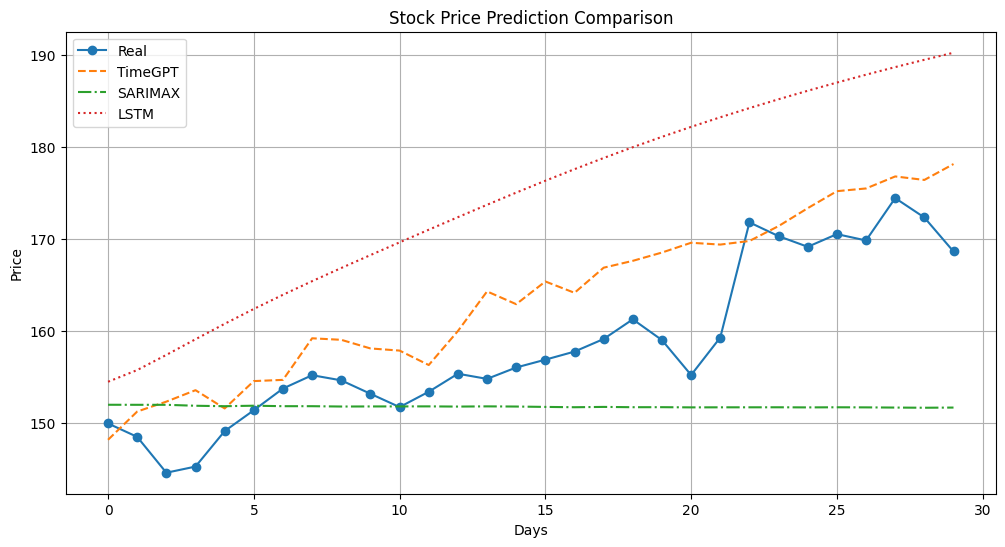

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设上面的数据已经保存在一个名为"data.csv"的文件中，每个值由逗号分隔
# 如果数据不在文件中，请先将数据保存到文件，或者直接在代码中创建DataFrame

# 读取数据
data = pd.DataFrame({
    "Real": [149.93, 148.47, 144.57, 145.24, 149.1, 151.37, 153.73, 155.18, 154.62, 153.16, 151.71, 153.38, 155.34, 154.78, 156.02, 156.87, 157.75, 159.12, 161.26, 159, 155.2, 159.28, 171.81, 170.31, 169.15, 170.53, 169.84, 174.45, 172.34, 168.64],
    "TimeGPT": [148.154327, 151.227051, 152.306274, 153.54985, 151.563538, 154.540268, 154.671997, 159.197052, 159.029907, 158.091736, 157.858353, 156.287262, 159.982956, 164.297974, 162.907379, 165.378418, 164.144196, 166.877029, 167.623642, 168.527588, 169.589905, 169.392059, 169.78299, 171.405914, 173.35318, 175.202515, 175.499069, 176.806061, 176.425354, 178.154526],
    "SARIMAX": [151.964016, 151.959479, 151.957979, 151.856326, 151.807478, 151.86137, 151.809143, 151.807889, 151.772214, 151.780735, 151.785094, 151.788534, 151.766839, 151.789251, 151.770538, 151.730243, 151.695274, 151.73029, 151.698024, 151.700912, 151.679657, 151.685975, 151.686919, 151.689691, 151.677622, 151.689872, 151.679701, 151.658854, 151.640341, 151.658826],
    "LSTM": [154.4667767, 155.7410303, 157.3890686, 159.0921442, 160.7715129, 162.3880149, 163.9319665, 165.4117652, 166.8447869, 168.2483077, 169.6347086, 171.0096462, 172.3735265, 173.7208488, 175.0455817, 176.3395026, 177.5967549, 178.8133864, 179.9864002, 181.114941, 182.2000888, 183.2422433, 184.2426844, 185.2041405, 186.1291279, 187.0190385, 187.8761333, 188.7021473, 189.4985792, 190.26689]
})

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(data['Real'], label='Real', marker='o')
plt.plot(data['TimeGPT'], label='TimeGPT', linestyle='--')
plt.plot(data['SARIMAX'], label='SARIMAX', linestyle='-.')
plt.plot(data['LSTM'], label='LSTM', linestyle=':')
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
